# Postings Release Analysis: BGI vs Lightcast Comparison

In [41]:
# Snowflake connection setup
import snowflake.connector as snow
import pandas as pd
import os
import importlib.util
import matplotlib.pyplot as plt

# Load credentials from config file
config_file_path = r"C:\Users\JuliaNania\OneDrive - Burning Glass Institute\Documents\Python\config.py"
spec = importlib.util.spec_from_file_location("config", config_file_path)
config = importlib.util.module_from_spec(spec)
spec.loader.exec_module(config)

# Establish connection
conn = snow.connect(
    user=config.credentials['USERNAME'],
    password=config.credentials['PASSWORD'],
    account='PCA67849',
    warehouse=config.credentials['WAREHOUSE'],
    database='PROJECT_DATA'
)
print("Connected to Snowflake")

Connected to Snowflake


In [3]:
# Helper function to run queries
def run_query(query):
    return pd.read_sql(query, conn)

## 1. Monthly Posting Counts Comparison
Comparing monthly job posting volumes between BGI and Lightcast

In [4]:
# Monthly posting counts: Lightcast US
lc_monthly_query = """
SELECT 
    DATE_TRUNC('month', POSTED) AS MONTH,
    COUNT(*) AS POSTING_COUNT
FROM BGI_POSTINGS_BACKUPS.DEC_25.US_POSTINGS
WHERE YEAR(POSTED) >= 2024 
GROUP BY 1
ORDER BY 1
"""
lc_monthly = run_query(lc_monthly_query)
lc_monthly['SOURCE'] = 'Lightcast'

# Monthly posting counts: BGI US
bgi_monthly_query = """
SELECT 
    DATE_TRUNC('month', POST_DATE) AS MONTH,
    COUNT(*) AS POSTING_COUNT
FROM revelio_clean.experimental_readonly.v2_postings_filtered 
WHERE BGI_COUNTRY = 'United States'
  AND YEAR(POST_DATE) >= 2024 
GROUP BY 1
ORDER BY 1
"""
bgi_monthly = run_query(bgi_monthly_query)
bgi_monthly['SOURCE'] = 'BGI'

# Combine for comparison
monthly_comparison = lc_monthly.merge(bgi_monthly, on='MONTH', suffixes=('_LC', '_BGI'))
monthly_comparison['MONTH_NAME'] = pd.to_datetime(monthly_comparison['MONTH']).dt.strftime('%b %Y')

display(monthly_comparison[['MONTH_NAME', 'POSTING_COUNT_LC', 'POSTING_COUNT_BGI']].style.format({
    'POSTING_COUNT_LC': '{:,.0f}',
    'POSTING_COUNT_BGI': '{:,.0f}'
}))

C:\Users\JuliaNania\AppData\Local\Temp\ipykernel_9148\1144319068.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, conn)
C:\Users\JuliaNania\AppData\Local\Temp\ipykernel_9148\1144319068.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, conn)


DatabaseError: Execution failed on sql '
SELECT 
    DATE_TRUNC('month', POST_DATE) AS MONTH,
    COUNT(*) AS POSTING_COUNT
FROM revelio_clean.experimental_readonly.v2_postings_filtered 
WHERE BGI_COUNTRY = 'United States'
  AND YEAR(POST_DATE) >= 2024 
GROUP BY 1
ORDER BY 1
': 000904 (42000): SQL compilation error: error line 5 at position 6
invalid identifier 'BGI_COUNTRY'

In [ ]:
# Line chart: Monthly posting counts comparison
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(monthly_comparison['MONTH_NAME'], monthly_comparison['POSTING_COUNT_LC'] / 1e6, 
        marker='o', linewidth=2, label='Lightcast', color='#C22036')
ax.plot(monthly_comparison['MONTH_NAME'], monthly_comparison['POSTING_COUNT_BGI'] / 1e6, 
        marker='s', linewidth=2, label='BGI', color='#03497A')

ax.set_xlabel('Month', fontname='Verdana')
ax.set_ylabel('Posting Count (Millions)', fontname='Verdana')
ax.set_title('Monthly US Job Posting Counts: BGI vs Lightcast', fontname='Verdana')
ax.legend(loc='upper right')
ax.yaxis.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45, ha='right')

fig.text(0.98, 0.02, 'Source: BGI analysis of Lightcast job postings', 
         ha='right', fontsize=9, fontname='Verdana')
plt.tight_layout()
plt.show()

## 2. Salary Analysis
Comprehensive salary comparison between BGI and Lightcast

### 2.1 Salary Key Stats Comparison
Comparing min, max, average, and median salary_min between BGI and Lightcast

In [ ]:
# Salary stats: Lightcast (salary_from = salary_min)
lc_salary_query = """
SELECT 
    'Lightcast' AS SOURCE,
    MIN(SALARY_FROM) AS MIN_SALARY_MIN,
    MAX(SALARY_FROM) AS MAX_SALARY_MIN,
    AVG(SALARY_FROM) AS AVG_SALARY_MIN,
    MEDIAN(SALARY_FROM) AS MEDIAN_SALARY_MIN,
    COUNT(*) AS N_POSTINGS_WITH_SALARY
FROM BGI_POSTINGS_BACKUPS.DEC_25.US_POSTINGS
WHERE SALARY_FROM IS NOT NULL AND SALARY_FROM > 0
"""
lc_salary = run_query(lc_salary_query)
display(lc_salary)

In [ ]:
# Salary stats: BGI (convert hourly to yearly if salary_per != 'year')
bgi_salary_query = """
SELECT 
    'BGI' AS SOURCE,
    MIN(YEARLY_SALARY_MIN) AS MIN_SALARY_MIN,
    MAX(YEARLY_SALARY_MIN) AS MAX_SALARY_MIN,
    AVG(YEARLY_SALARY_MIN) AS AVG_SALARY_MIN,
    MEDIAN(YEARLY_SALARY_MIN) AS MEDIAN_SALARY_MIN,
    COUNT(*) AS N_POSTINGS_WITH_SALARY
FROM (
    SELECT 
        CASE 
            WHEN LOWER(SALARY_PER) = 'year' THEN PARSED_SALARY_MIN
            WHEN LOWER(SALARY_PER) = 'hour' THEN PARSED_SALARY_MIN * 2000
            WHEN LOWER(SALARY_PER) = 'week' THEN PARSED_SALARY_MIN * 50
            WHEN LOWER(SALARY_PER) = 'day' THEN PARSED_SALARY_MIN * 260 
            WHEN LOWER(SALARY_PER) = 'month' THEN PARSED_SALARY_MIN * 12
            WHEN LOWER(SALARY_PER) = 'piece' THEN NULL 
            ELSE PARSED_SALARY_MIN
        END AS YEARLY_SALARY_MIN
    FROM REVELIO_CLEAN.V1.BGI_POSTINGS p 
        INNER JOIN temporary_data.dsexton.salary_infer_full_eval sal ON sal.desc_id = p.desc_id
    WHERE PARSED_SALARY_MIN IS NOT NULL AND PARSED_SALARY_MIN > 0
      AND BGI_COUNTRY = 'United States'
)
"""
bgi_salary = run_query(bgi_salary_query)
display(bgi_salary)

In [ ]:
# Combined salary comparison table
salary_comparison = pd.concat([lc_salary, bgi_salary], ignore_index=True)
display(salary_comparison.style.format('{:,.2f}', subset=['MIN_SALARY_MIN', 'MAX_SALARY_MIN', 'AVG_SALARY_MIN', 'MEDIAN_SALARY_MIN']))

### 2.2 Salary Distribution
Distribution of minimum salary (annualized)

In [ ]:
# Query salary distribution in $10k buckets up to $200k + one ">200k" bucket
# Filtered to year 2025 only
lc_dist_query = """
SELECT 
    CASE 
        WHEN SALARY_FROM > 200000 THEN 210000
        ELSE FLOOR(SALARY_FROM / 10000) * 10000 
    END AS SALARY_BUCKET,
    COUNT(*) AS COUNT
FROM BGI_POSTINGS_BACKUPS.DEC_25.US_POSTINGS
WHERE SALARY_FROM IS NOT NULL AND SALARY_FROM > 0
  AND YEAR(POSTED) = 2025
GROUP BY 1
ORDER BY 1
"""
lc_dist = run_query(lc_dist_query)

# Get total LC postings with salary for percentage calculation (2025 only)
lc_total = run_query("""
SELECT COUNT(*) AS TOTAL FROM BGI_POSTINGS_BACKUPS.DEC_25.US_POSTINGS
WHERE SALARY_FROM IS NOT NULL AND SALARY_FROM > 0
  AND YEAR(POSTED) = 2025
""")['TOTAL'].iloc[0]

bgi_dist_query = """
SELECT 
    CASE 
        WHEN YEARLY_SALARY_MIN > 200000 THEN 210000
        ELSE FLOOR(YEARLY_SALARY_MIN / 10000) * 10000 
    END AS SALARY_BUCKET,
    COUNT(*) AS COUNT
FROM (
    SELECT 
        CASE 
            WHEN LOWER(SALARY_PER) = 'year' THEN PARSED_SALARY_MIN
            WHEN LOWER(SALARY_PER) = 'hour' THEN PARSED_SALARY_MIN * 2000
            WHEN LOWER(SALARY_PER) = 'week' THEN PARSED_SALARY_MIN * 50
            WHEN LOWER(SALARY_PER) = 'day' THEN PARSED_SALARY_MIN * 260 
            WHEN LOWER(SALARY_PER) = 'month' THEN PARSED_SALARY_MIN * 12
            WHEN LOWER(SALARY_PER) = 'piece' THEN NULL
            ELSE PARSED_SALARY_MIN
        END AS YEARLY_SALARY_MIN
    FROM REVELIO_CLEAN.V1.BGI_POSTINGS p 
        INNER JOIN temporary_data.dsexton.salary_infer_full_eval sal ON sal.desc_id = p.desc_id
    WHERE PARSED_SALARY_MIN IS NOT NULL AND PARSED_SALARY_MIN > 0
      AND BGI_COUNTRY = 'United States'
      AND YEAR(p.POST_DATE) = 2025
)
GROUP BY 1
ORDER BY 1
"""
bgi_dist = run_query(bgi_dist_query)

# Get total BGI postings with salary for percentage calculation (2025 only)
bgi_total = run_query("""
SELECT COUNT(*) AS TOTAL FROM (
    SELECT 1
    FROM REVELIO_CLEAN.V1.BGI_POSTINGS p 
        INNER JOIN temporary_data.dsexton.salary_infer_full_eval sal ON sal.desc_id = p.desc_id
    WHERE PARSED_SALARY_MIN IS NOT NULL AND PARSED_SALARY_MIN > 0
      AND BGI_COUNTRY = 'United States'
      AND YEAR(p.POST_DATE) = 2025
)
""")['TOTAL'].iloc[0]

# Convert to percentages based on full 2025 dataset
lc_dist['PCT'] = lc_dist['COUNT'] / lc_total * 100
bgi_dist['PCT'] = bgi_dist['COUNT'] / bgi_total * 100

# Merge to align buckets for charting
salary_dist = lc_dist[['SALARY_BUCKET', 'PCT']].rename(columns={'PCT': 'LC_PCT'}).merge(
    bgi_dist[['SALARY_BUCKET', 'PCT']].rename(columns={'PCT': 'BGI_PCT'}),
    on='SALARY_BUCKET', how='outer'
).fillna(0).sort_values('SALARY_BUCKET')

print(f"LC total postings with salary (2025): {lc_total:,}")
print(f"BGI total postings with salary (2025): {bgi_total:,}")

In [ ]:
# Chart: Salary distribution with >200k bucket (2025 only)
fig, ax = plt.subplots(figsize=(14, 6))
x = salary_dist['SALARY_BUCKET']
width = 4000

ax.bar(x - width/2, salary_dist['LC_PCT'], width, label='Lightcast', color='#C22036')
ax.bar(x + width/2, salary_dist['BGI_PCT'], width, label='BGI', color='#03497A')
ax.set_xlabel('Salary Bucket ($)', fontname='Verdana')
ax.set_ylabel('% of Postings', fontname='Verdana')
ax.set_title('Distribution of Minimum Salary (2025)', fontname='Verdana')
ax.legend(loc='upper right')

# Custom formatter to show ">200k" for the 210000 bucket
def format_salary(x, _):
    if x == 210000:
        return '>$200k'
    return f'${x/1000:.0f}k'
ax.xaxis.set_major_formatter(plt.FuncFormatter(format_salary))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0f}'))
ax.yaxis.grid(True, linestyle='--', alpha=0.7)
fig.text(0.98, 0.02, 'Source: BGI analysis of Lightcast job postings', 
         ha='right', fontsize=9, fontname='Verdana')
plt.tight_layout()
plt.show()

### 2.3 Salary Outliers
Examples of very high and very low salary values

In [42]:
# Examples of very high salary_min values with original SALARY_TEXT
high_salary_query = """
SELECT 
    sal.DESC_ID,
    sal.SALARY_TEXT,
    sal.PARSED_SALARY_MIN,
    sal.SALARY_PER,
    CASE 
        WHEN LOWER(SALARY_PER) = 'year' THEN PARSED_SALARY_MIN
        WHEN LOWER(SALARY_PER) = 'hour' THEN PARSED_SALARY_MIN * 2000
        WHEN LOWER(SALARY_PER) = 'week' THEN PARSED_SALARY_MIN * 50
        WHEN LOWER(SALARY_PER) = 'day' THEN PARSED_SALARY_MIN * 260 
        WHEN LOWER(SALARY_PER) = 'month' THEN PARSED_SALARY_MIN * 12
        ELSE PARSED_SALARY_MIN
    END AS YEARLY_SALARY_MIN
FROM REVELIO_CLEAN.V1.BGI_POSTINGS p 
    INNER JOIN temporary_data.dsexton.salary_infer_full_eval sal ON sal.desc_id = p.desc_id
WHERE PARSED_SALARY_MIN IS NOT NULL AND PARSED_SALARY_MIN > 0
  AND BGI_COUNTRY = 'United States'
ORDER BY YEARLY_SALARY_MIN DESC
LIMIT 20
"""
high_salary_examples = run_query(high_salary_query)
print("=== Very High Salary Examples ===")
display(high_salary_examples)

C:\Users\JuliaNania\AppData\Local\Temp\ipykernel_9148\1144319068.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, conn)


=== Very High Salary Examples ===


,DESC_ID,SALARY_TEXT,PARSED_SALARY_MIN,SALARY_PER,YEARLY_SALARY_MIN
0,034e1e6159a100649eb84fe66c480475,Grammarly offers all team members competitive ...,1.500002e+50,year,1.500002e+50
1,5d652b5cf85c666cc7c41b73a3655b30,"CB Neptune Holdings, LLC has immediate availab...",9.506095e+44,NA,9.506095e+44
2,48923ef8721d5af45354bc7e3cb55d54,"Pay is based upon experience and, as establish...",5.180555e+44,NA,5.180555e+44
3,ea122cd92547212a93e52fb75124931e,2023-24 School Year Prior Years of Experience ...,3.367370e+44,NA,3.367370e+44
4,bd9df8a5cc484ace50415ec04c2af1ff,Pay based upon experience and as established b...,3.367370e+44,NA,3.367370e+44
5,f03e4e2abb902092fa79fd043fd657c6,Pay based upon experience and as established b...,2.357269e+44,NA,2.357269e+44
6,3a12696ca4714fa2482fc68f3de2c827,Pay based upon experience and as established b...,2.357269e+44,NA,2.357269e+44
7,a54c8c4d7755a1a8119c7ee80877618c,Pay based upon experience and as established b...,2.357269e+44,NA,2.357269e+44
8,6ad30c488020d8510429dd36e38f0055,Pay based upon experience and as established b...,2.357269e+44,NA,2.357269e+44
9,aae294ac02c47e7d2c66ec9532336ee2,Grammarly offers all team members competitive ...,1.570002e+44,year,1.570002e+44


In [43]:
# Examples of very low salary_min values with original SALARY_TEXT
low_salary_query = """
SELECT 
    sal.DESC_ID,
    sal.SALARY_TEXT,
    sal.PARSED_SALARY_MIN,
    sal.SALARY_PER,
    CASE 
        WHEN LOWER(SALARY_PER) = 'year' THEN PARSED_SALARY_MIN
        WHEN LOWER(SALARY_PER) = 'hour' THEN PARSED_SALARY_MIN * 2000
        WHEN LOWER(SALARY_PER) = 'week' THEN PARSED_SALARY_MIN * 50
        WHEN LOWER(SALARY_PER) = 'day' THEN PARSED_SALARY_MIN * 260 
        WHEN LOWER(SALARY_PER) = 'month' THEN PARSED_SALARY_MIN * 12
        ELSE PARSED_SALARY_MIN
    END AS YEARLY_SALARY_MIN
FROM REVELIO_CLEAN.V1.BGI_POSTINGS p 
    INNER JOIN temporary_data.dsexton.salary_infer_full_eval sal ON sal.desc_id = p.desc_id
WHERE PARSED_SALARY_MIN IS NOT NULL AND PARSED_SALARY_MIN > 0
  AND BGI_COUNTRY = 'United States'
ORDER BY YEARLY_SALARY_MIN ASC
LIMIT 20
"""
low_salary_examples = run_query(low_salary_query)
print("=== Very Low Salary Examples ===")
display(low_salary_examples)

C:\Users\JuliaNania\AppData\Local\Temp\ipykernel_9148\1144319068.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, conn)


=== Very Low Salary Examples ===


,DESC_ID,SALARY_TEXT,PARSED_SALARY_MIN,SALARY_PER,YEARLY_SALARY_MIN
0,6b4f447a2ad21bb465742939a03645a0,"Overview: 0.000001- FTE, contingent position: ...",0.000001,NA,0.000001
1,50cb97409c1625c5b5a4461042244857,New employees are paid only by direct deposit ...,0.000005,NA,0.000005
2,50cb97409c1625c5b5a4461042244857,New employees are paid only by direct deposit ...,0.000005,NA,0.000005
3,f783ac71f9bc35ef7c75c2b66cb55842,Job Category: Academic/Research Position Type:...,0.000100,NA,0.000100
4,bcf5c3b0526a619f257df6622590fda0,"- Job Category: Academic/Research, - Job Speci...",0.000100,NA,0.000100
5,6c919728b92f1888833df3a5903f41d5,Type: Full-time Shift Length: 8-hour shift Shi...,0.000100,NA,0.000100
6,18bb75b0b0b57c93596748e0efe9df66,**Position Type:** Full-time. **Shift Length:*...,0.000100,NA,0.000100
7,75c0ac45809ade6533e69ad8756ac646,Working Title: Visiting Postdoctoral Scientist...,0.000100,NA,0.000100
8,805a0ea9e018393f5643d8acfba6fb19,---* Position Type: Full-time\n ---* Shift Len...,0.000100,NA,0.000100
9,f13ad9cf4056be3e508cc03d6aa1fbc5,Category: Students/Interns/Trainees Position T...,0.000100,NA,0.000100


### 2.4 Median Min Salary by SOC 2 Occupation
Comparing median minimum salary across broad occupation categories

In [ ]:
# Median min salary by SOC 2 occupation - Lightcast
lc_soc2_query = """
SELECT 
    SOC_2_NAME AS SOC2,
    MEDIAN(SALARY_FROM) AS MEDIAN_SALARY_MIN,
    COUNT(*) AS N_POSTINGS
FROM BGI_POSTINGS_BACKUPS.DEC_25.US_POSTINGS
WHERE SALARY_FROM IS NOT NULL AND SALARY_FROM > 0
  AND YEAR(POSTED) = 2025
  AND SOC_2_NAME IS NOT NULL
GROUP BY 1
ORDER BY 2 DESC
"""
lc_soc2 = run_query(lc_soc2_query)
lc_soc2['SOURCE'] = 'Lightcast'

# Median min salary by SOC 2 occupation - BGI
bgi_soc2_query = """
SELECT 
    lu.BGI_SOC2_NAME AS SOC2,
    MEDIAN(YEARLY_SALARY_MIN) AS MEDIAN_SALARY_MIN,
    COUNT(*) AS N_POSTINGS
FROM (
    SELECT 
        p.ONET_CODE,
        CASE 
            WHEN LOWER(SALARY_PER) = 'year' THEN PARSED_SALARY_MIN
            WHEN LOWER(SALARY_PER) = 'hour' THEN PARSED_SALARY_MIN * 2000
            WHEN LOWER(SALARY_PER) = 'week' THEN PARSED_SALARY_MIN * 50
            WHEN LOWER(SALARY_PER) = 'day' THEN PARSED_SALARY_MIN * 260 
            WHEN LOWER(SALARY_PER) = 'month' THEN PARSED_SALARY_MIN * 12
            WHEN LOWER(SALARY_PER) = 'piece' THEN NULL
            ELSE PARSED_SALARY_MIN
        END AS YEARLY_SALARY_MIN
    FROM REVELIO_CLEAN.V1.BGI_POSTINGS p 
        INNER JOIN temporary_data.dsexton.salary_infer_full_eval sal ON sal.desc_id = p.desc_id
    WHERE PARSED_SALARY_MIN IS NOT NULL AND PARSED_SALARY_MIN > 0
      AND BGI_COUNTRY = 'United States'
      AND YEAR(p.POST_DATE) = 2025
) sub
INNER JOIN temporary_data.jnania.onet_soc_lookup lu ON lu.bgi_onet = sub.ONET_CODE
WHERE YEARLY_SALARY_MIN IS NOT NULL AND YEARLY_SALARY_MIN <= 500000
GROUP BY 1
ORDER BY 2 DESC
"""
bgi_soc2 = run_query(bgi_soc2_query)
bgi_soc2['SOURCE'] = 'BGI'

# Merge for comparison
soc2_comparison = lc_soc2[['SOC2', 'MEDIAN_SALARY_MIN']].rename(columns={'MEDIAN_SALARY_MIN': 'LC_MEDIAN'}).merge(
    bgi_soc2[['SOC2', 'MEDIAN_SALARY_MIN']].rename(columns={'MEDIAN_SALARY_MIN': 'BGI_MEDIAN'}),
    on='SOC2', how='outer'
).fillna(0).sort_values('LC_MEDIAN', ascending=True)

display(soc2_comparison)

In [ ]:
# Horizontal bar chart: Median min salary by SOC 2 occupation
import numpy as np

# Filter out military and unclassified occupations
soc2_chart = soc2_comparison[~soc2_comparison['SOC2'].str.lower().str.contains('military|unclassified', na=False)]

fig, ax = plt.subplots(figsize=(12, 10))
y = np.arange(len(soc2_chart))
height = 0.35

ax.barh(y - height/2, soc2_chart['LC_MEDIAN'], height, label='Lightcast', color='#C22036')
ax.barh(y + height/2, soc2_chart['BGI_MEDIAN'], height, label='BGI', color='#03497A')

ax.set_xlabel('Median Minimum Salary ($)', fontname='Verdana')
ax.set_ylabel('SOC 2 Occupation', fontname='Verdana')
ax.set_title('Median Minimum Salary by SOC 2 Occupation (2025)', fontname='Verdana')
ax.set_yticks(y)
ax.set_yticklabels(soc2_chart['SOC2'], fontname='Verdana', fontsize=10)
ax.legend(loc='lower right')
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x/1000:.0f}k'))
ax.xaxis.grid(True, linestyle='--', alpha=0.7)

fig.text(0.98, 0.02, 'Source: BGI analysis of Lightcast job postings', 
         ha='right', fontsize=9, fontname='Verdana')
plt.tight_layout()
plt.show()

In [ ]:
# Analyze similarity between LC and BGI median salaries by SOC 2
from scipy import stats

# Use filtered data (exclude military/unclassified and rows with 0 values)
soc2_valid = soc2_chart[(soc2_chart['LC_MEDIAN'] > 0) & (soc2_chart['BGI_MEDIAN'] > 0)].copy()

# Calculate difference metrics
soc2_valid['DIFF'] = soc2_valid['LC_MEDIAN'] - soc2_valid['BGI_MEDIAN']
soc2_valid['ABS_DIFF'] = soc2_valid['DIFF'].abs()
soc2_valid['PCT_DIFF'] = (soc2_valid['DIFF'] / soc2_valid['LC_MEDIAN']) * 100

# Correlation
correlation, p_value = stats.pearsonr(soc2_valid['LC_MEDIAN'], soc2_valid['BGI_MEDIAN'])

# Summary statistics
print("=== Similarity Analysis: Median Min Salary by SOC 2 ===\n")
print(f"Number of SOC 2 categories compared: {len(soc2_valid)}")
print(f"\nCorrelation (Pearson r): {correlation:.3f} (p-value: {p_value:.4f})")
print(f"\nMean absolute difference: ${soc2_valid['ABS_DIFF'].mean():,.0f}")
print(f"Median absolute difference: ${soc2_valid['ABS_DIFF'].median():,.0f}")
print(f"\nMean % difference (LC vs BGI): {soc2_valid['PCT_DIFF'].mean():.1f}%")
print(f"Median % difference: {soc2_valid['PCT_DIFF'].median():.1f}%")

# Show detailed comparison
print("\n=== Detailed Comparison by SOC 2 ===")
display(soc2_valid.sort_values('ABS_DIFF', ascending=False)[['SOC2', 'LC_MEDIAN', 'BGI_MEDIAN', 'DIFF', 'PCT_DIFF']])

In [ ]:
# Scatter plot: LC vs BGI median salary by SOC 2
fig, ax = plt.subplots(figsize=(10, 8))

ax.scatter(soc2_valid['LC_MEDIAN'], soc2_valid['BGI_MEDIAN'], color='#03497A', s=80, alpha=0.7)

# Add diagonal reference line (perfect agreement)
max_val = max(soc2_valid['LC_MEDIAN'].max(), soc2_valid['BGI_MEDIAN'].max())
ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.5, label='Perfect agreement')

# Add regression line
slope, intercept, r, p, se = stats.linregress(soc2_valid['LC_MEDIAN'], soc2_valid['BGI_MEDIAN'])
x_line = np.array([0, max_val])
ax.plot(x_line, slope * x_line + intercept, color='#C22036', label=f'Regression (r={r:.2f})')

ax.set_xlabel('Lightcast Median Min Salary ($)', fontname='Verdana')
ax.set_ylabel('BGI Median Min Salary ($)', fontname='Verdana')
ax.set_title('LC vs BGI: Median Min Salary by SOC 2 (2025)', fontname='Verdana')
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x/1000:.0f}k'))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'${y/1000:.0f}k'))
ax.legend(loc='upper left')
ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

### 2.5 Salary Coverage Analysis
What percentage of job postings have a minimum salary?

In [23]:
# Salary coverage: % of postings with minimum salary (2025)

# Lightcast US coverage
lc_us_coverage_query = """
SELECT 
    'US' AS COUNTRY,
    COUNT(*) AS TOTAL_POSTINGS,
    SUM(CASE WHEN SALARY_FROM IS NOT NULL AND SALARY_FROM > 0 THEN 1 ELSE 0 END) AS POSTINGS_WITH_SALARY
FROM BGI_POSTINGS_BACKUPS.DEC_25.US_POSTINGS
WHERE YEAR(POSTED) = 2025
"""
lc_us_coverage = run_query(lc_us_coverage_query)
lc_us_coverage['SOURCE'] = 'Lightcast'

# Lightcast UK coverage
lc_uk_coverage_query = """
SELECT 
    'UK' AS COUNTRY,
    COUNT(*) AS TOTAL_POSTINGS,
    SUM(CASE WHEN SALARY_FROM IS NOT NULL AND SALARY_FROM > 0 THEN 1 ELSE 0 END) AS POSTINGS_WITH_SALARY
FROM BGI_POSTINGS_BACKUPS.DEC_25.UK_POSTINGS
WHERE YEAR(POSTED) = 2025
"""
lc_uk_coverage = run_query(lc_uk_coverage_query)
lc_uk_coverage['SOURCE'] = 'Lightcast'

# Lightcast Hong Kong coverage
lc_hk_coverage_query = """
SELECT 
    'HK' AS COUNTRY,
    COUNT(*) AS TOTAL_POSTINGS,
    SUM(CASE WHEN SALARY_FROM IS NOT NULL AND SALARY_FROM > 0 THEN 1 ELSE 0 END) AS POSTINGS_WITH_SALARY
FROM BGI_POSTINGS_BACKUPS.DEC_25.GLOBAL_POSTINGS
WHERE LAA_COUNTRY_NAME = 'Hong Kong'
  AND YEAR(POSTED) = 2025
"""
lc_hk_coverage = run_query(lc_hk_coverage_query)
lc_hk_coverage['SOURCE'] = 'Lightcast'

# BGI US coverage
bgi_us_coverage_query = """
SELECT 
    'US' AS COUNTRY,
    COUNT(*) AS TOTAL_POSTINGS,
    SUM(CASE WHEN sal.PARSED_SALARY_MIN IS NOT NULL AND sal.PARSED_SALARY_MIN > 0 THEN 1 ELSE 0 END) AS POSTINGS_WITH_SALARY
FROM REVELIO_CLEAN.V1.BGI_POSTINGS p
LEFT JOIN temporary_data.dsexton.salary_infer_full_eval sal ON sal.desc_id = p.desc_id
WHERE BGI_COUNTRY = 'United States'
  AND YEAR(p.POST_DATE) = 2025
"""
bgi_us_coverage = run_query(bgi_us_coverage_query)
bgi_us_coverage['SOURCE'] = 'BGI'

# BGI UK coverage
bgi_uk_coverage_query = """
SELECT 
    'UK' AS COUNTRY,
    COUNT(*) AS TOTAL_POSTINGS,
    SUM(CASE WHEN sal.PARSED_SALARY_MIN IS NOT NULL AND sal.PARSED_SALARY_MIN > 0 THEN 1 ELSE 0 END) AS POSTINGS_WITH_SALARY
FROM REVELIO_CLEAN.V1.BGI_POSTINGS p
LEFT JOIN temporary_data.dsexton.salary_infer_full_eval sal ON sal.desc_id = p.desc_id
WHERE BGI_COUNTRY = 'United Kingdom'
  AND YEAR(p.POST_DATE) = 2025
"""
bgi_uk_coverage = run_query(bgi_uk_coverage_query)
bgi_uk_coverage['SOURCE'] = 'BGI'

# BGI Hong Kong coverage
bgi_hk_coverage_query = """
SELECT 
    'HK' AS COUNTRY,
    COUNT(*) AS TOTAL_POSTINGS,
    SUM(CASE WHEN sal.PARSED_SALARY_MIN IS NOT NULL AND sal.PARSED_SALARY_MIN > 0 THEN 1 ELSE 0 END) AS POSTINGS_WITH_SALARY
FROM REVELIO_CLEAN.V1.BGI_POSTINGS p
LEFT JOIN temporary_data.dsexton.salary_infer_full_eval sal ON sal.desc_id = p.desc_id
WHERE BGI_COUNTRY = 'Hong Kong'
  AND YEAR(p.POST_DATE) = 2025
"""
bgi_hk_coverage = run_query(bgi_hk_coverage_query)
bgi_hk_coverage['SOURCE'] = 'BGI'

# Combine all
coverage_comparison = pd.concat([lc_us_coverage, lc_uk_coverage, lc_hk_coverage, 
                                  bgi_us_coverage, bgi_uk_coverage, bgi_hk_coverage], ignore_index=True)
coverage_comparison['PCT_WITH_SALARY'] = (coverage_comparison['POSTINGS_WITH_SALARY'] / coverage_comparison['TOTAL_POSTINGS']) * 100
coverage_comparison = coverage_comparison[['SOURCE', 'COUNTRY', 'TOTAL_POSTINGS', 'POSTINGS_WITH_SALARY', 'PCT_WITH_SALARY']]

print("=== Salary Coverage: Job Postings (2025) ===\n")
display(coverage_comparison.style.format({
    'TOTAL_POSTINGS': '{:,.0f}',
    'POSTINGS_WITH_SALARY': '{:,.0f}',
    'PCT_WITH_SALARY': '{:.1f}%'
}))

C:\Users\JuliaNania\AppData\Local\Temp\ipykernel_9148\1144319068.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, conn)
C:\Users\JuliaNania\AppData\Local\Temp\ipykernel_9148\1144319068.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, conn)
C:\Users\JuliaNania\AppData\Local\Temp\ipykernel_9148\1144319068.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, conn)
C:\Users\JuliaNania\AppData\Local\Temp\ipykernel_9148\1144319068.py:3: UserWarning

=== Salary Coverage: Job Postings (2025) ===



,SOURCE,COUNTRY,TOTAL_POSTINGS,POSTINGS_WITH_SALARY,PCT_WITH_SALARY
0,Lightcast,US,"37,584,743","20,400,267",54.3%
1,Lightcast,UK,"7,871,309","3,802,236",48.3%
2,Lightcast,HK,"396,758","100,209",25.3%
3,BGI,US,"338,492,928","120,660,750",35.6%
4,BGI,UK,"6,585,316","2,674,773",40.6%
5,BGI,HK,"249,517","13,476",5.4%


# 3. Occupation Analysis

### 3.1 ONET Coverage
Comparing the number of postings with ONET classification between BGI and Lightcast

In [4]:
# ONET coverage: count postings where ONET is not null

# Lightcast: count postings with ONET_2019_NAME
lc_onet_query = """
SELECT 
    COUNT(*) AS TOTAL_POSTINGS,
    SUM(CASE WHEN ONET_2019_NAME IS NOT NULL THEN 1 ELSE 0 END) AS POSTINGS_WITH_ONET
FROM BGI_POSTINGS_BACKUPS.DEC_25.US_POSTINGS
"""
lc_onet = run_query(lc_onet_query)
lc_onet['SOURCE'] = 'Lightcast'

# BGI: count postings with TOP1_CODE from occupation classifier
bgi_onet_query = """
SELECT 
    COUNT(*) AS TOTAL_POSTINGS,
    SUM(CASE WHEN TOP1_CODE IS NOT NULL THEN 1 ELSE 0 END) AS POSTINGS_WITH_ONET
FROM PROJECT_DATA.POSTINGS_OCCUPATION_CLASSIFIER.CLEAN_POSTINGS_V2_NEW_RUN_ALL
"""
bgi_onet = run_query(bgi_onet_query)
bgi_onet['SOURCE'] = 'BGI'

# Combine and calculate percentages
onet_coverage = pd.concat([lc_onet, bgi_onet], ignore_index=True)
onet_coverage['PCT_WITH_ONET'] = (onet_coverage['POSTINGS_WITH_ONET'] / onet_coverage['TOTAL_POSTINGS']) * 100
onet_coverage = onet_coverage[['SOURCE', 'TOTAL_POSTINGS', 'POSTINGS_WITH_ONET', 'PCT_WITH_ONET']]

print("=== ONET Coverage: Postings with Occupation Classification ===\n")
display(onet_coverage.style.format({
    'TOTAL_POSTINGS': '{:,.0f}',
    'POSTINGS_WITH_ONET': '{:,.0f}',
    'PCT_WITH_ONET': '{:.1f}%'
}))

C:\Users\JuliaNania\AppData\Local\Temp\ipykernel_41720\1144319068.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, conn)
C:\Users\JuliaNania\AppData\Local\Temp\ipykernel_41720\1144319068.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, conn)


=== ONET Coverage: Postings with Occupation Classification ===



,SOURCE,TOTAL_POSTINGS,POSTINGS_WITH_ONET,PCT_WITH_ONET
0,Lightcast,"471,644,043","471,644,043",100.0%
1,BGI,"383,725,377","383,725,377",100.0%


### 3.2 Distribution by SOC 2 Occupation
Comparing posting distribution across broad occupation categories

In [18]:
# Distribution by SOC 2 occupation (Lightcast, BGI v1, BGI v2)

# Lightcast: distribution by SOC_2_NAME
lc_soc2_dist_query = """
SELECT 
    SOC_2_NAME,
    COUNT(*) AS POSTING_COUNT
FROM BGI_POSTINGS_BACKUPS.DEC_25.US_POSTINGS
WHERE SOC_2_NAME IS NOT NULL and year(posted) = 2024
GROUP BY 1
ORDER BY 2 DESC
"""
lc_soc2_dist = run_query(lc_soc2_dist_query)
lc_total_with_soc = lc_soc2_dist['POSTING_COUNT'].sum()
lc_soc2_dist['PCT'] = (lc_soc2_dist['POSTING_COUNT'] / lc_total_with_soc) * 100

# BGI v1: distribution by BGI_SOC2_NAME
bgi_v1_soc2_dist_query = """
SELECT 
    BGI_SOC2_NAME AS SOC_2_NAME,
    COUNT(*) AS POSTING_COUNT
FROM REVELIO_CLEAN.V1.BGI_POSTINGS
WHERE BGI_SOC2_NAME IS NOT NULL 
  AND BGI_COUNTRY = 'United States'
  AND YEAR(POST_DATE) = 2025
GROUP BY 1
ORDER BY 2 DESC
"""
bgi_v1_soc2_dist = run_query(bgi_v1_soc2_dist_query)
bgi_v1_total_with_soc = bgi_v1_soc2_dist['POSTING_COUNT'].sum()
bgi_v1_soc2_dist['PCT'] = (bgi_v1_soc2_dist['POSTING_COUNT'] / bgi_v1_total_with_soc) * 100

# BGI v2: join occupation classifier with lookup table to get SOC 2 names
bgi_v2_soc2_dist_query = """
SELECT 
    lu.BGI_SOC2_NAME AS SOC_2_NAME,
    COUNT(*) AS POSTING_COUNT
FROM PROJECT_DATA.POSTINGS_OCCUPATION_CLASSIFIER.CLEAN_POSTINGS_V2_NEW_RUN_ALL occ
INNER JOIN revelio_clean.experimental_readonly.v2_postings_filtered p ON p.desc_id = occ.desc_id 
INNER JOIN temporary_data.jnania.onet_soc_lookup lu ON lu.BGI_ONET = occ.TOP1_CODE
WHERE occ.TOP1_CODE IS NOT NULL AND YEAR(p.post_date) = 2024
GROUP BY 1
ORDER BY 2 DESC
"""
bgi_v2_soc2_dist = run_query(bgi_v2_soc2_dist_query)
bgi_v2_total_with_soc = bgi_v2_soc2_dist['POSTING_COUNT'].sum()
bgi_v2_soc2_dist['PCT'] = (bgi_v2_soc2_dist['POSTING_COUNT'] / bgi_v2_total_with_soc) * 100

# Merge all three for side-by-side comparison
soc2_dist_comparison = lc_soc2_dist[['SOC_2_NAME', 'POSTING_COUNT', 'PCT']].rename(
    columns={'POSTING_COUNT': 'LC_COUNT', 'PCT': 'LC_PCT'}
).merge(
    bgi_v1_soc2_dist[['SOC_2_NAME', 'POSTING_COUNT', 'PCT']].rename(
        columns={'POSTING_COUNT': 'BGI_V1_COUNT', 'PCT': 'BGI_V1_PCT'}
    ),
    on='SOC_2_NAME', how='outer'
).merge(
    bgi_v2_soc2_dist[['SOC_2_NAME', 'POSTING_COUNT', 'PCT']].rename(
        columns={'POSTING_COUNT': 'BGI_V2_COUNT', 'PCT': 'BGI_V2_PCT'}
    ),
    on='SOC_2_NAME', how='outer'
).fillna(0).sort_values('LC_PCT', ascending=False)

print(f"Lightcast total postings with SOC 2: {lc_total_with_soc:,.0f}")
print(f"BGI v1 total postings with SOC 2: {bgi_v1_total_with_soc:,.0f}")
print(f"BGI v2 total postings with SOC 2: {bgi_v2_total_with_soc:,.0f}\n")
display(soc2_dist_comparison.style.format({
    'LC_COUNT': '{:,.0f}',
    'BGI_V1_COUNT': '{:,.0f}',
    'BGI_V2_COUNT': '{:,.0f}',
    'LC_PCT': '{:.1f}%',
    'BGI_V1_PCT': '{:.1f}%',
    'BGI_V2_PCT': '{:.1f}%'
}))

C:\Users\JuliaNania\AppData\Local\Temp\ipykernel_9148\1144319068.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, conn)
C:\Users\JuliaNania\AppData\Local\Temp\ipykernel_9148\1144319068.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, conn)
C:\Users\JuliaNania\AppData\Local\Temp\ipykernel_9148\1144319068.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, conn)


Lightcast total postings with SOC 2: 36,821,414
BGI v1 total postings with SOC 2: 47,557,935
BGI v2 total postings with SOC 2: 113,575,955



,SOC_2_NAME,LC_COUNT,LC_PCT,BGI_V1_COUNT,BGI_V1_PCT,BGI_V2_COUNT,BGI_V2_PCT
10,Healthcare Practitioners and Technical Occupations,"5,900,033",16.0%,"9,975,720",21.0%,"19,263,932",17.0%
22,Sales and Related Occupations,"3,736,257",10.1%,"4,192,992",8.8%,"11,340,914",10.0%
15,Management Occupations,"3,718,706",10.1%,"4,161,956",8.8%,"8,887,370",7.8%
18,Office and Administrative Support Occupations,"2,912,740",7.9%,"3,199,958",6.7%,"9,608,245",8.5%
3,Business and Financial Operations Occupations,"2,427,762",6.6%,"2,479,214",5.2%,"6,976,509",6.1%
5,Computer and Mathematical Occupations,"2,201,005",6.0%,"2,604,481",5.5%,"7,012,250",6.2%
23,Transportation and Material Moving Occupations,"2,129,955",5.8%,"4,684,160",9.8%,"8,372,842",7.4%
9,Food Preparation and Serving Related Occupations,"1,774,595",4.8%,"2,393,254",5.0%,"6,524,924",5.7%
12,"Installation, Maintenance, and Repair Occupations","1,634,179",4.4%,"1,671,700",3.5%,"4,882,126",4.3%
11,Healthcare Support Occupations,"1,421,716",3.9%,"2,051,090",4.3%,"5,195,259",4.6%


In [19]:
# SOC2 with largest differences between Lightcast and BGI v2
soc2_diff = soc2_dist_comparison[['SOC_2_NAME', 'LC_PCT', 'BGI_V2_PCT']].copy()
soc2_diff['DIFF'] = soc2_diff['LC_PCT'] - soc2_diff['BGI_V2_PCT']  # positive = LC higher
soc2_diff['ABS_DIFF'] = soc2_diff['DIFF'].abs()
soc2_diff = soc2_diff.sort_values('ABS_DIFF', ascending=False)

print("=== SOC2 with Largest Differences: Lightcast vs BGI v2 ===\n")
display(soc2_diff.head(10).style.format({
    'LC_PCT': '{:.1f}%',
    'BGI_V2_PCT': '{:.1f}%',
    'DIFF': '{:+.1f}pp',
    'ABS_DIFF': '{:.1f}pp'
}))

=== SOC2 with Largest Differences: Lightcast vs BGI v2 ===



,SOC_2_NAME,LC_PCT,BGI_V2_PCT,DIFF,ABS_DIFF
15,Management Occupations,10.1%,7.8%,+2.3pp,2.3pp
24,Unclassified Occupation,2.2%,0.0%,+2.2pp,2.2pp
23,Transportation and Material Moving Occupations,5.8%,7.4%,-1.6pp,1.6pp
19,Personal Care and Service Occupations,1.4%,2.4%,-1.1pp,1.1pp
10,Healthcare Practitioners and Technical Occupations,16.0%,17.0%,-0.9pp,0.9pp
9,Food Preparation and Serving Related Occupations,4.8%,5.7%,-0.9pp,0.9pp
1,"Arts, Design, Entertainment, Sports, and Media Occupations",2.3%,1.5%,+0.8pp,0.8pp
20,Production Occupations,3.3%,2.5%,+0.8pp,0.8pp
11,Healthcare Support Occupations,3.9%,4.6%,-0.7pp,0.7pp
18,Office and Administrative Support Occupations,7.9%,8.5%,-0.5pp,0.5pp


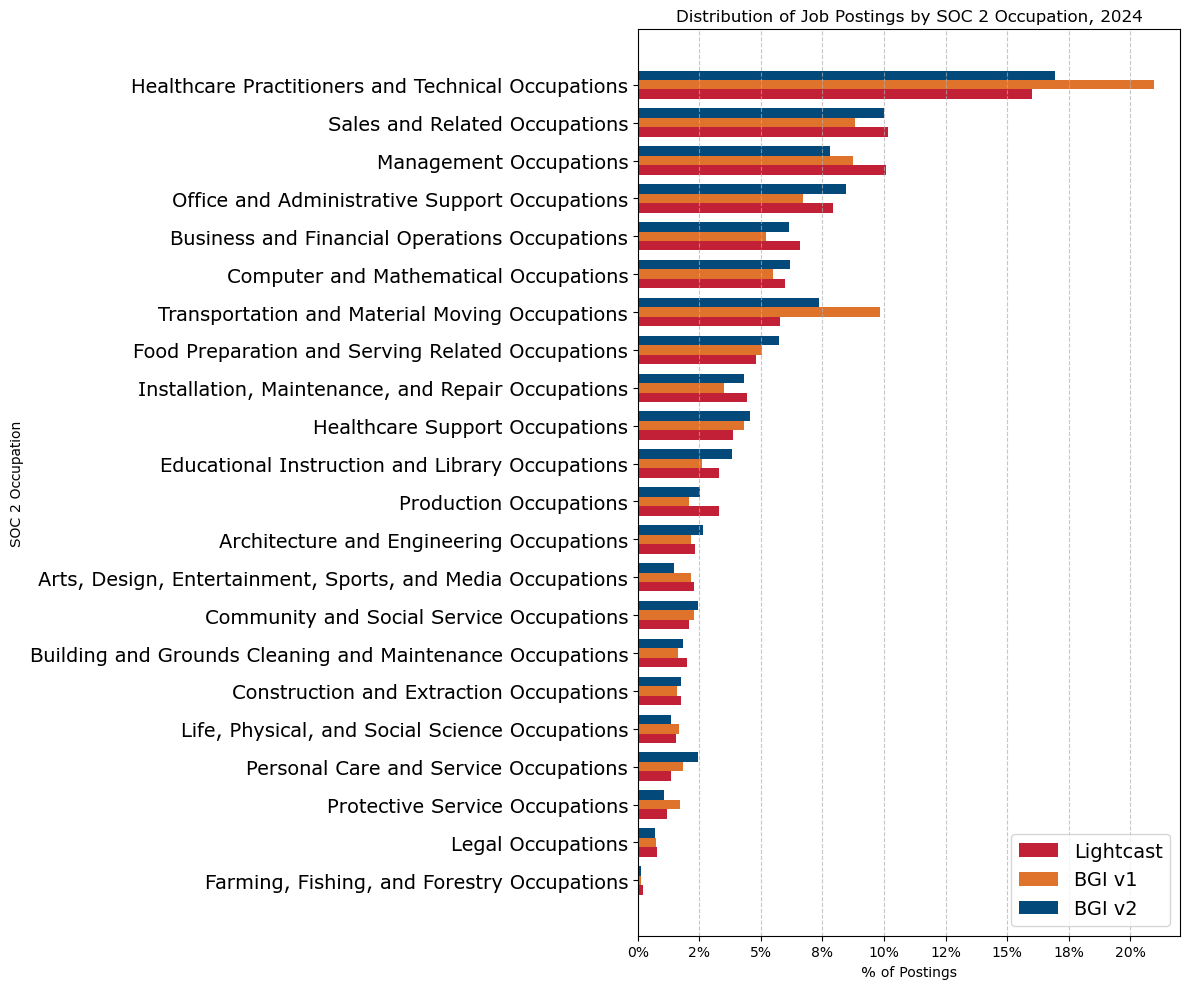

In [17]:
# Chart: SOC 2 distribution comparison (horizontal bar) - 3 sources
import numpy as np

# Filter out military/unclassified and sort by LC percentage
soc2_chart_data = soc2_dist_comparison[
    ~soc2_dist_comparison['SOC_2_NAME'].str.lower().str.contains('military|unclassified', na=False)
].sort_values('LC_PCT', ascending=True)

fig, ax = plt.subplots(figsize=(12, 10))
y = np.arange(len(soc2_chart_data))
height = 0.25  # narrower bars for 3 groups

ax.barh(y - height, soc2_chart_data['LC_PCT'], height, label='Lightcast', color='#C22036')
ax.barh(y, soc2_chart_data['BGI_V1_PCT'], height, label='BGI v1', color='#E0732B')
ax.barh(y + height, soc2_chart_data['BGI_V2_PCT'], height, label='BGI v2', color='#03497A')

ax.set_xlabel('% of Postings', fontname='Verdana')
ax.set_ylabel('SOC 2 Occupation', fontname='Verdana')
ax.set_title('Distribution of Job Postings by SOC 2 Occupation, 2024', fontname='Verdana')
ax.set_yticks(y)
ax.set_yticklabels(soc2_chart_data['SOC_2_NAME'], fontname='Verdana', fontsize=14)
ax.legend(loc='lower right', fontsize = 14)
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}%'))
ax.xaxis.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

### 3.3 ONET Classification Changes: BGI v1 vs v2
Analyzing which ONET codes changed between BGI v1 and v2 classifications for 2024 postings

In [20]:
# Most common ONET changes between BGI v1 and v2 (2024)
onet_changes_query = """
SELECT 
    v1.ONET_CODE AS V1_ONET,
    lu_v1.BGI_ONET_NAME AS V1_ONET_NAME,
    occ.TOP1_CODE AS V2_ONET,
    lu_v2.BGI_ONET_NAME AS V2_ONET_NAME,
    COUNT(*) AS POSTING_COUNT
FROM REVELIO_CLEAN.V1.BGI_POSTINGS v1
INNER JOIN PROJECT_DATA.POSTINGS_OCCUPATION_CLASSIFIER.CLEAN_POSTINGS_V2_NEW_RUN_ALL occ 
    ON occ.DESC_ID = v1.DESC_ID
LEFT JOIN temporary_data.jnania.onet_soc_lookup lu_v1 ON lu_v1.BGI_ONET = v1.ONET_CODE
LEFT JOIN temporary_data.jnania.onet_soc_lookup lu_v2 ON lu_v2.BGI_ONET = occ.TOP1_CODE
WHERE v1.BGI_COUNTRY = 'United States'
  AND YEAR(v1.POST_DATE) = 2024
  AND v1.ONET_CODE IS NOT NULL
  AND occ.TOP1_CODE IS NOT NULL
  AND v1.ONET_CODE != occ.TOP1_CODE  -- only show changes
GROUP BY 1, 2, 3, 4
ORDER BY 5 DESC
LIMIT 30
"""
onet_changes = run_query(onet_changes_query)

print("=== Most Common ONET Classification Changes: BGI v1 → v2 (2024) ===\n")
display(onet_changes.style.format({'POSTING_COUNT': '{:,.0f}'}))

C:\Users\JuliaNania\AppData\Local\Temp\ipykernel_9148\1144319068.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, conn)


=== Most Common ONET Classification Changes: BGI v1 → v2 (2024) ===



,V1_ONET,V1_ONET_NAME,V2_ONET,V2_ONET_NAME,POSTING_COUNT
0,29-2061.00,Licensed Practical and Licensed Vocational Nurses,29-1141.00,Registered Nurses,"3,332,259"
1,53-3033.00,Light Truck Drivers,53-3032.00,Heavy and Tractor-Trailer Truck Drivers,"1,617,452"
2,11-9111.00,Medical and Health Services Managers,29-1141.00,Registered Nurses,"704,379"
3,41-1011.00,First-Line Supervisors of Retail Sales Workers,41-2031.00,Retail Salespersons,"668,254"
4,47-5041.00,Continuous Mining Machine Operators,53-3032.00,Heavy and Tractor-Trailer Truck Drivers,"626,012"
5,35-3041.00,"Food Servers, Nonrestaurant",35-3023.00,Fast Food and Counter Workers,"549,764"
6,31-1121.00,Home Health Aides,31-1122.00,Personal Care Aides,"544,092"
7,29-2061.00,Licensed Practical and Licensed Vocational Nurses,29-1141.01,Acute Care Nurses,"434,997"
8,31-1121.00,Home Health Aides,31-1131.00,Nursing Assistants,"416,569"
9,31-9097.00,Phlebotomists,31-9092.00,Medical Assistants,"405,517"


In [21]:
# Summary: How many postings changed ONET classification?
onet_change_summary_query = """
SELECT 
    SUM(CASE WHEN v1.ONET_CODE = occ.TOP1_CODE THEN 1 ELSE 0 END) AS SAME_ONET,
    SUM(CASE WHEN v1.ONET_CODE != occ.TOP1_CODE THEN 1 ELSE 0 END) AS DIFFERENT_ONET,
    COUNT(*) AS TOTAL_MATCHED
FROM REVELIO_CLEAN.V1.BGI_POSTINGS v1
INNER JOIN PROJECT_DATA.POSTINGS_OCCUPATION_CLASSIFIER.CLEAN_POSTINGS_V2_NEW_RUN_ALL occ 
    ON occ.DESC_ID = v1.DESC_ID
WHERE v1.BGI_COUNTRY = 'United States'
  AND YEAR(v1.POST_DATE) = 2024
  AND v1.ONET_CODE IS NOT NULL
  AND occ.TOP1_CODE IS NOT NULL
"""
onet_summary = run_query(onet_change_summary_query)
onet_summary['PCT_SAME'] = (onet_summary['SAME_ONET'] / onet_summary['TOTAL_MATCHED']) * 100
onet_summary['PCT_CHANGED'] = (onet_summary['DIFFERENT_ONET'] / onet_summary['TOTAL_MATCHED']) * 100

print("=== ONET Classification Agreement: BGI v1 vs v2 (2024) ===\n")
display(onet_summary.style.format({
    'SAME_ONET': '{:,.0f}',
    'DIFFERENT_ONET': '{:,.0f}',
    'TOTAL_MATCHED': '{:,.0f}',
    'PCT_SAME': '{:.1f}%',
    'PCT_CHANGED': '{:.1f}%'
}))

C:\Users\JuliaNania\AppData\Local\Temp\ipykernel_9148\1144319068.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, conn)


=== ONET Classification Agreement: BGI v1 vs v2 (2024) ===



,SAME_ONET,DIFFERENT_ONET,TOTAL_MATCHED,PCT_SAME,PCT_CHANGED
0,"13,388,297","85,067,282","98,455,579",13.6%,86.4%


## 4. Industry Analysis
Comparing job posting distribution by NAICS 2 industry between Lightcast, BGI v1, and BGI v2

### 4.1 Distribution by NAICS 2 Industry
Comparing posting distribution across broad industry categories

In [27]:
# Distribution by NAICS 2 industry (Lightcast, BGI v1, BGI v2)

# Lightcast: distribution by NAICS2_NAME
lc_naics2_query = """
SELECT 
    NAICS2_NAME,
    COUNT(*) AS POSTING_COUNT
FROM BGI_POSTINGS_BACKUPS.DEC_25.US_POSTINGS
WHERE NAICS2_NAME IS NOT NULL AND YEAR(POSTED) = 2024
GROUP BY 1
ORDER BY 2 DESC
"""
lc_naics2 = run_query(lc_naics2_query)
lc_total_naics = lc_naics2['POSTING_COUNT'].sum()
lc_naics2['PCT'] = (lc_naics2['POSTING_COUNT'] / lc_total_naics) * 100

# BGI v1: distribution by BGI_NAICS2_NAME
bgi_v1_naics2_query = """
SELECT 
    BGI_NAICS2_NAME AS NAICS2_NAME,
    COUNT(*) AS POSTING_COUNT
FROM REVELIO_CLEAN.V1.BGI_POSTINGS
WHERE BGI_NAICS2_NAME IS NOT NULL 
  AND BGI_COUNTRY = 'United States'
  AND YEAR(POST_DATE) = 2024
GROUP BY 1
ORDER BY 2 DESC
"""
bgi_v1_naics2 = run_query(bgi_v1_naics2_query)
bgi_v1_total_naics = bgi_v1_naics2['POSTING_COUNT'].sum()
bgi_v1_naics2['PCT'] = (bgi_v1_naics2['POSTING_COUNT'] / bgi_v1_total_naics) * 100

# BGI v2: join with employer data and NAICS hierarchy
bgi_v2_naics2_query = """
SELECT 
    nh.naics_2022_2_name AS NAICS2_NAME,
    COUNT(*) AS POSTING_COUNT
FROM REVELIO_CLEAN.EXPERIMENTAL_READONLY.V2_POSTINGS_FILTERED posts
LEFT JOIN TEMPORARY_DATA.MBONE.MISSING_RCIDS_V2 miss ON posts.JOB_ID = miss.JOB_ID
LEFT JOIN TEMPORARY_DATA.MBONE.MASTER_EMPLOYERS_V2 emps ON COALESCE(miss.IMPUTED_RCID, posts.RCID) = emps.REV_BASE_ID
INNER JOIN TEMPORARY_DATA.SSWEE.NAICS_FULL_HIERARCHY nh ON nh.naics_2022_6 = emps.BGI_NAICS_TOP1
WHERE emps.BGI_NAICS_TOP1 IS NOT NULL
  AND posts.country = 'United States'
  AND YEAR(posts.POST_DATE) = 2024
GROUP BY 1
ORDER BY 2 DESC
"""
bgi_v2_naics2 = run_query(bgi_v2_naics2_query)
bgi_v2_total_naics = bgi_v2_naics2['POSTING_COUNT'].sum()
bgi_v2_naics2['PCT'] = (bgi_v2_naics2['POSTING_COUNT'] / bgi_v2_total_naics) * 100

# Merge all three for side-by-side comparison
naics2_comparison = lc_naics2[['NAICS2_NAME', 'POSTING_COUNT', 'PCT']].rename(
    columns={'POSTING_COUNT': 'LC_COUNT', 'PCT': 'LC_PCT'}
).merge(
    bgi_v1_naics2[['NAICS2_NAME', 'POSTING_COUNT', 'PCT']].rename(
        columns={'POSTING_COUNT': 'BGI_V1_COUNT', 'PCT': 'BGI_V1_PCT'}
    ),
    on='NAICS2_NAME', how='outer'
).merge(
    bgi_v2_naics2[['NAICS2_NAME', 'POSTING_COUNT', 'PCT']].rename(
        columns={'POSTING_COUNT': 'BGI_V2_COUNT', 'PCT': 'BGI_V2_PCT'}
    ),
    on='NAICS2_NAME', how='outer'
).fillna(0).sort_values('LC_PCT', ascending=False)

print(f"Lightcast total postings with NAICS 2: {lc_total_naics:,.0f}")
print(f"BGI v1 total postings with NAICS 2: {bgi_v1_total_naics:,.0f}")
print(f"BGI v2 total postings with NAICS 2: {bgi_v2_total_naics:,.0f}\n")
display(naics2_comparison.style.format({
    'LC_COUNT': '{:,.0f}',
    'BGI_V1_COUNT': '{:,.0f}',
    'BGI_V2_COUNT': '{:,.0f}',
    'LC_PCT': '{:.1f}%',
    'BGI_V1_PCT': '{:.1f}%',
    'BGI_V2_PCT': '{:.1f}%'
}))

C:\Users\JuliaNania\AppData\Local\Temp\ipykernel_9148\1144319068.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, conn)
C:\Users\JuliaNania\AppData\Local\Temp\ipykernel_9148\1144319068.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, conn)
C:\Users\JuliaNania\AppData\Local\Temp\ipykernel_9148\1144319068.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, conn)


Lightcast total postings with NAICS 2: 36,821,414
BGI v1 total postings with NAICS 2: 89,305,262
BGI v2 total postings with NAICS 2: 92,026,177



,NAICS2_NAME,LC_COUNT,LC_PCT,BGI_V1_COUNT,BGI_V1_PCT,BGI_V2_COUNT,BGI_V2_PCT
7,Health Care and Social Assistance,"5,732,182",15.6%,"13,959,833",15.6%,"11,373,718",12.4%
18,Unclassified Industry,"5,490,238",14.9%,0,0.0%,0,0.0%
1,Administrative and Support and Waste Management and Remediation Services,"4,948,004",13.4%,"24,512,034",27.4%,"21,984,133",23.9%
16,Retail Trade,"3,422,409",9.3%,"6,991,543",7.8%,"7,131,749",7.7%
13,"Professional, Scientific, and Technical Services","3,027,719",8.2%,"9,543,792",10.7%,"8,088,227",8.8%
10,Manufacturing,"2,488,325",6.8%,"4,545,946",5.1%,"7,295,972",7.9%
0,Accommodation and Food Services,"1,857,052",5.0%,"5,266,923",5.9%,"5,494,226",6.0%
5,Educational Services,"1,840,582",5.0%,"4,868,691",5.5%,"5,737,836",6.2%
6,Finance and Insurance,"1,453,015",3.9%,"3,281,328",3.7%,"5,329,240",5.8%
20,Wholesale Trade,"1,104,387",3.0%,"2,000,138",2.2%,"1,568,573",1.7%


In [40]:
# NAICS2 with largest differences between Lightcast and BGI v2
naics2_diff_lc = naics2_comparison[['NAICS2_NAME', 'LC_PCT', 'BGI_V2_PCT']].copy()
naics2_diff_lc['DIFF'] = naics2_diff_lc['LC_PCT'] - naics2_diff_lc['BGI_V2_PCT']  # positive = LC higher
naics2_diff_lc['ABS_DIFF'] = naics2_diff_lc['DIFF'].abs()
naics2_diff_lc = naics2_diff_lc.sort_values('ABS_DIFF', ascending=False)

print("=== NAICS2 with Largest Differences: Lightcast vs BGI v2 ===\n")
display(naics2_diff_lc.head(10).style.format({
    'LC_PCT': '{:.1f}%',
    'BGI_V2_PCT': '{:.1f}%',
    'DIFF': '{:+.1f}pp',
    'ABS_DIFF': '{:.1f}pp'
}))

# NAICS2 with largest differences between BGI v1 and BGI v2
naics2_diff_bgi = naics2_comparison[['NAICS2_NAME', 'BGI_V1_PCT', 'BGI_V2_PCT']].copy()
naics2_diff_bgi['DIFF'] = naics2_diff_bgi['BGI_V2_PCT'] - naics2_diff_bgi['BGI_V1_PCT']  # positive = v1 higher
naics2_diff_bgi['ABS_DIFF'] = naics2_diff_bgi['DIFF'].abs()
naics2_diff_bgi = naics2_diff_bgi.sort_values('ABS_DIFF', ascending=False)

print("\n=== NAICS2 with Largest Differences: BGI v1 vs BGI v2 ===\n")
display(naics2_diff_bgi.head(10).style.format({
    'BGI_V1_PCT': '{:.1f}%',
    'BGI_V2_PCT': '{:.1f}%',
    'DIFF': '{:+.1f}pp',
    'ABS_DIFF': '{:.1f}pp'
}))

=== NAICS2 with Largest Differences: Lightcast vs BGI v2 ===



,NAICS2_NAME,LC_PCT,BGI_V2_PCT,DIFF,ABS_DIFF
18,Unclassified Industry,14.9%,0.0%,+14.9pp,14.9pp
1,Administrative and Support and Waste Management and Remediation Services,13.4%,23.9%,-10.5pp,10.5pp
7,Health Care and Social Assistance,15.6%,12.4%,+3.2pp,3.2pp
8,Information,2.1%,4.3%,-2.2pp,2.2pp
6,Finance and Insurance,3.9%,5.8%,-1.8pp,1.8pp
14,Public Administration,2.1%,3.8%,-1.6pp,1.6pp
16,Retail Trade,9.3%,7.7%,+1.5pp,1.5pp
17,Transportation and Warehousing,2.1%,3.4%,-1.3pp,1.3pp
20,Wholesale Trade,3.0%,1.7%,+1.3pp,1.3pp
5,Educational Services,5.0%,6.2%,-1.2pp,1.2pp



=== NAICS2 with Largest Differences: BGI v1 vs BGI v2 ===



,NAICS2_NAME,BGI_V1_PCT,BGI_V2_PCT,DIFF,ABS_DIFF
1,Administrative and Support and Waste Management and Remediation Services,27.4%,23.9%,-3.6pp,3.6pp
7,Health Care and Social Assistance,15.6%,12.4%,-3.3pp,3.3pp
10,Manufacturing,5.1%,7.9%,+2.8pp,2.8pp
8,Information,1.9%,4.3%,+2.3pp,2.3pp
6,Finance and Insurance,3.7%,5.8%,+2.1pp,2.1pp
13,"Professional, Scientific, and Technical Services",10.7%,8.8%,-1.9pp,1.9pp
3,"Arts, Entertainment, and Recreation",0.9%,1.8%,+0.9pp,0.9pp
14,Public Administration,2.8%,3.8%,+0.9pp,0.9pp
5,Educational Services,5.5%,6.2%,+0.8pp,0.8pp
12,Other Services (except Public Administration),2.5%,1.9%,-0.6pp,0.6pp


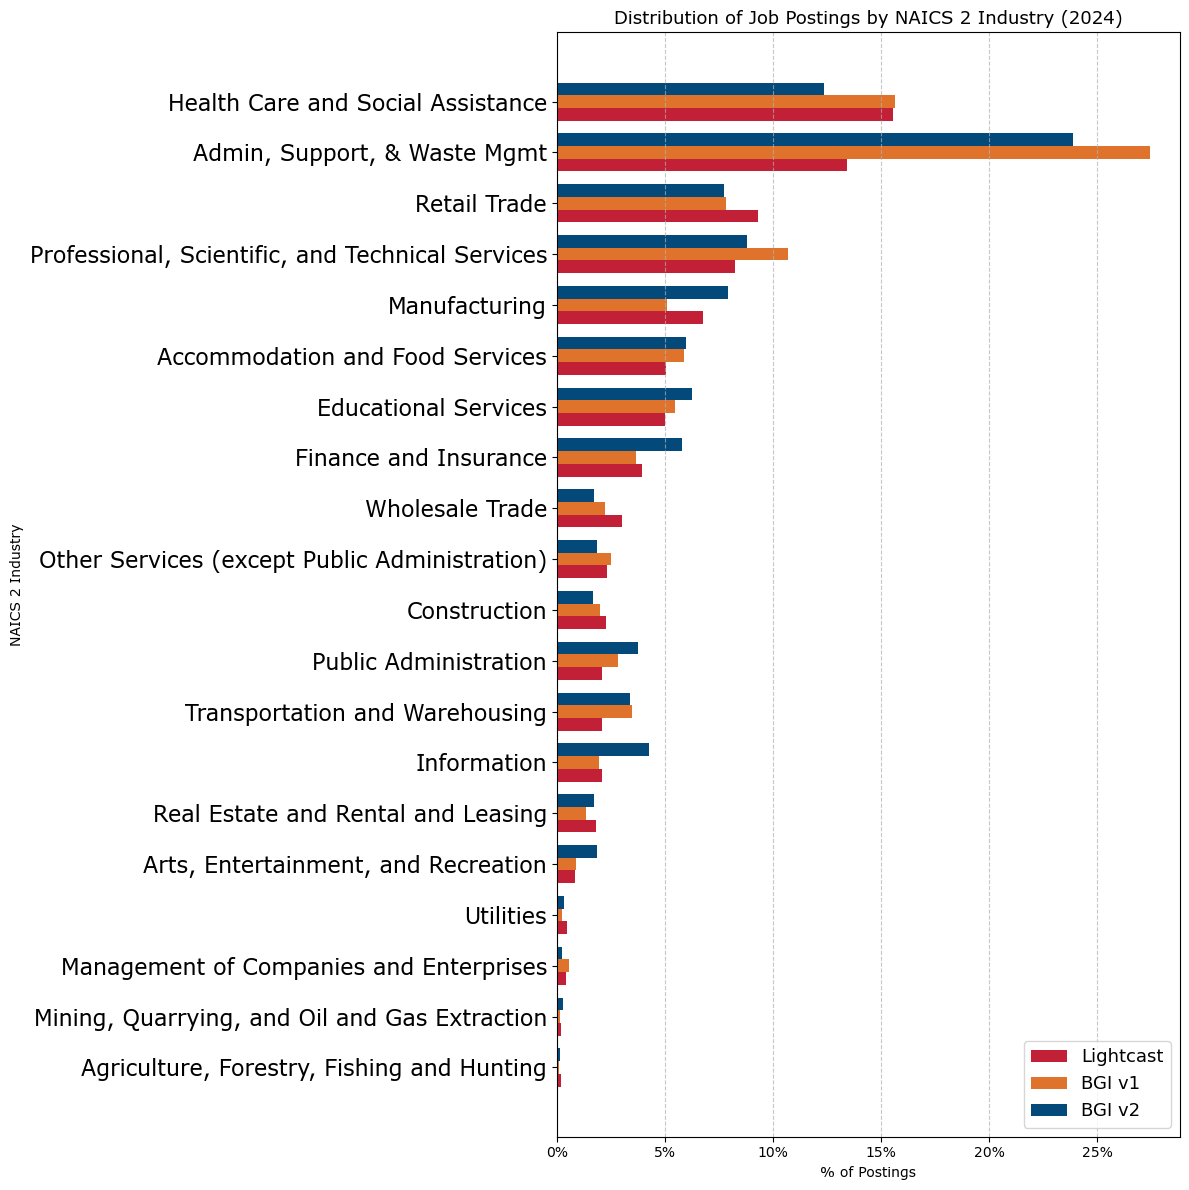

In [38]:
# Chart: NAICS 2 distribution comparison (horizontal bar) - 3 sources
import numpy as np

# Sort by LC percentage for charting, shorten long label, exclude Unclassified
naics2_chart_data = naics2_comparison.copy()
naics2_chart_data = naics2_chart_data[~naics2_chart_data['NAICS2_NAME'].str.contains('Unclassified', na=False)]
naics2_chart_data['NAICS2_NAME'] = naics2_chart_data['NAICS2_NAME'].replace(
    'Administrative and Support and Waste Management and Remediation Services', 
    'Admin, Support, & Waste Mgmt')
naics2_chart_data = naics2_chart_data.sort_values('LC_PCT', ascending=True)

fig, ax = plt.subplots(figsize=(12, 12))
y = np.arange(len(naics2_chart_data))
height = 0.25  # narrower bars for 3 groups

ax.barh(y - height, naics2_chart_data['LC_PCT'], height, label='Lightcast', color='#C22036')
ax.barh(y, naics2_chart_data['BGI_V1_PCT'], height, label='BGI v1', color='#E0732B')
ax.barh(y + height, naics2_chart_data['BGI_V2_PCT'], height, label='BGI v2', color='#03497A')

ax.set_xlabel('% of Postings', fontname='Verdana')
ax.set_ylabel('NAICS 2 Industry', fontname='Verdana')
ax.set_title('Distribution of Job Postings by NAICS 2 Industry (2024)', fontname='Verdana', fontsize = 13)
ax.set_yticks(y)
ax.set_yticklabels(naics2_chart_data['NAICS2_NAME'], fontname='Verdana', fontsize=16)
ax.legend(loc='lower right', fontsize = 13)
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}%'))
ax.xaxis.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()